# Testing UniRef Model

In [1]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import numpy as np

# Load model
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

# Load into GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval() 

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.17.layer.2.DenseReluDense.wo.weight', 'decoder.block.19.layer.0.SelfAttention.o.weight', 'decoder.block.22.layer.0.SelfAttention.q.weight', 'decoder.block.1.layer.2.layer_norm.weight', 'decoder.block.2.layer.2.DenseReluDense.wo.weight', 'decoder.block.8.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.0.SelfAttention.v.weight', 'decoder.block.1.layer.1.EncDecAttention.v.weight', 'decoder.block.23.layer.2.DenseReluDense.wo.weight', 'decoder.block.12.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.2.DenseReluDense.wi.weight', 'decoder.block.19.layer.2.layer_norm.weight', 'decoder.block.14.layer.1.EncDecAttention.o.weight', 'decoder.block.21.layer.1.EncDecAttention.k.weight', 'decoder.block.22.layer.0.layer_norm.weight', 'decoder.block.19.layer.1.layer_norm.weight', 'decoder.block.16.layer.1.EncDecAttention.o.weight', 'decoder.block.8.layer.0.S

In [38]:
# Tokenize, encode, and load example sequences
ex_seq = ["A T W","A T E"]
ex_seq = [re.sub(r"[UZOB]", "X", sequence) for sequence in ex_seq]
ids = tokenizer.batch_encode_plus(ex_seq, add_special_tokens=True, padding=True)
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

# Extract sequence features
with torch.no_grad():
    embedding = model(input_ids=input_ids,attention_mask=attention_mask)
embedding = embedding.last_hidden_state.cpu().numpy()

# Remove padding and special tokens
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    features.append(seq_emd)
features

[array([[ 0.1265764 , -0.13151374, -0.2601224 , ...,  0.00458627,
         -0.05920463, -0.04529901],
        [ 0.2802877 , -0.10432567, -0.425026  , ...,  0.18578516,
         -0.09256832, -0.15548012],
        [ 0.07381413,  0.01820545, -0.00343402, ...,  0.11101398,
         -0.12984815, -0.02367226]], dtype=float32),
 array([[ 0.15986352, -0.2527481 , -0.15840194, ...,  0.06446997,
         -0.05601623, -0.13918552],
        [ 0.23181392, -0.2732637 , -0.30261785, ..., -0.03905839,
          0.1586108 , -0.00670971],
        [ 0.16332299, -0.10366669,  0.10422383, ...,  0.167325  ,
         -0.17385639,  0.02975434]], dtype=float32)]

# Encoding Real Protein Sequences

In [65]:
from Bio import SeqIO

# Use biopython to parse fasta file and append sequences to list
sequences = []
with open("sequence.fasta") as file:
    for seq in SeqIO.parse(file, 'fasta'):

        # Add space after each character so each amino acid is vectorized
        seq = str(seq.seq)
        seq = ' '.join([*seq])
        sequences.append(seq)

# Use two sequences for testing
seq1 = sequences[4]
seq2 = sequences[6]
sequences = [seq1, seq2]

In [66]:
# Tokenize, encode, pad
ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True)
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

# Extract sequence features
with torch.no_grad():
    embedding = model(input_ids=input_ids,attention_mask=attention_mask)  #decoder_input_ids for decoder weights
embedding = embedding.last_hidden_state.cpu().numpy()

# Remove padding and special tokens
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    features.append(seq_emd)
features

[array([[ 0.08533021, -0.19546583,  0.16062105, ..., -0.03790493,
         -0.03070347,  0.31730485],
        [-0.03431857, -0.29238957,  0.22645675, ..., -0.11935304,
          0.14813834,  0.38654387],
        [ 0.31403413, -0.4437057 ,  0.19872722, ..., -0.05748946,
          0.28448614,  0.34276745],
        ...,
        [ 0.20868456,  0.02878062,  0.18790261, ..., -0.04504645,
          0.10416568,  0.00503535],
        [-0.15428656, -0.06379218,  0.04651554, ..., -0.06407882,
         -0.05461382,  0.30456603],
        [ 0.07383008, -0.10731578,  0.15481226, ..., -0.10743617,
          0.0836371 ,  0.07375476]], dtype=float32),
 array([[ 0.02017053, -0.08296076,  0.03315902, ...,  0.03821034,
         -0.0348434 ,  0.18585998],
        [ 0.15897956, -0.19068712,  0.2012503 , ...,  0.13078968,
         -0.01037263,  0.11338541],
        [ 0.18045308, -0.25436854,  0.19193846, ..., -0.07226748,
          0.15368618,  0.2645616 ],
        ...,
        [ 0.16377099, -0.16201524, -0.1

Number of vectors is half the length of a sequence with individual amino acids due to the space characters delineating each residue.

# Finding Significant Cosine Similarity Between Embedded Amino Acids

In [94]:
import numpy as np
from numpy.linalg import norm

# Find cosine similarity distribution
cos_scores = []
for i, vec1 in enumerate(features[0]):
    vec2 = features[1][i]
    cos_scores.append(np.dot(vec1,vec2)/(norm(vec1)*norm(vec2)))

In [88]:
# BLOSUM64 matrix
blosum = [[4,0,-2,-1,-2,0,-2,-1,-1,-1,-1,-2,-1,-1,-1,1,0,0,-3,-2],
[0,9,-3,-4,-2,-3,-3,-1,-3,-1,-1,-3,-3,-3,-3,-1,-1,-1,-2,-2],
[-2,-3,6,2,-3,-1,-1,-3,-1,-4,-3,1,-1,0,-2,0,-1,-3,-4,-3],
[-1,-4,2,5,-3,-2,0,-3,1,-3,-2,0,-1,2,0,0,-1,-2,-3,-2],
[-2,-2,-3,-3,6,-3,-1,0,-3,0,0,-3,-4,-3,-3,-2,-2,-1,1,3],
[0,-3,-1,-2,-3,6,-2,-4,-2,-4,-3,0,-2,-2,-2,0,-2,-3,-2,-3],
[-2,-3,-1,0,-1,-2,8,-3,-1,-3,-2,1,-2,0,0,-1,-2,-3,-2,2],
[-1,-1,-3,-3,0,-4,-3,4,-3,2,1,-3,-3,-3,-3,-2,-1,3,-3,-1],
[-1,-3,-1,1,-3,-2,-1,-3,5,-2,-1,0,-1,1,2,0,-1,-2,-3,-2],
[-1,-1,-4,-3,0,-4,-3,2,-2,4,2,-3,-3,-2,-2,-2,-1,1,-2,-1],
[-1,-1,-3,-2,0,-3,-2,1,-1,2,5,-2,-2,0,-1,-1,-1,1,-1,-1],
[-2,-3,1,0,-3,0,1,-3,0,-3,-2,6,-2,0,0,1,0,-3,-4,-2],
[-1,-3,-1,-1,-4,-2,-2,-3,-1,-3,-2,-2,7,-1,-2,-1,-1,-2,-4,-3],
[-1,-3,0,2,-3,-2,0,-3,1,-2,0,0,-1,5,1,0,-1,-2,-2,-1],
[-1,-3,-2,0,-3,-2,0,-3,2,-2,-1,0,-2,1,5,-1,-1,-3,-3,-2],
[1,-1,0,0,-2,0,-1,-2,0,-2,-1,1,-1,0,-1,4,1,-2,-3,-2],
[0,-1,-1,-1,-2,-2,-2,-1,-1,-1,-1,0,-1,-1,-1,1,5,0,-2,-2],
[0,-1,-3,-2,-1,-3,-3,3,-2,1,1,-3,-2,-2,-3,-2,0,4,-3,-1],
[-3,-2,-4,-3,1,-2,-2,-3,-3,-2,-1,-4,-4,-2,-3,-3,-2,-3,11,2],
[-2,-2,-3,-2,3,-3,2,-1,-2,-1,-1,-2,-3,-1,-2,-2,-2,-1,2,7]]

# Add all into one list
blosum_scores = []
for list in blosum:
    for score in list:
        blosum_scores.append(score)

Text(0, 0.5, 'Frequency')

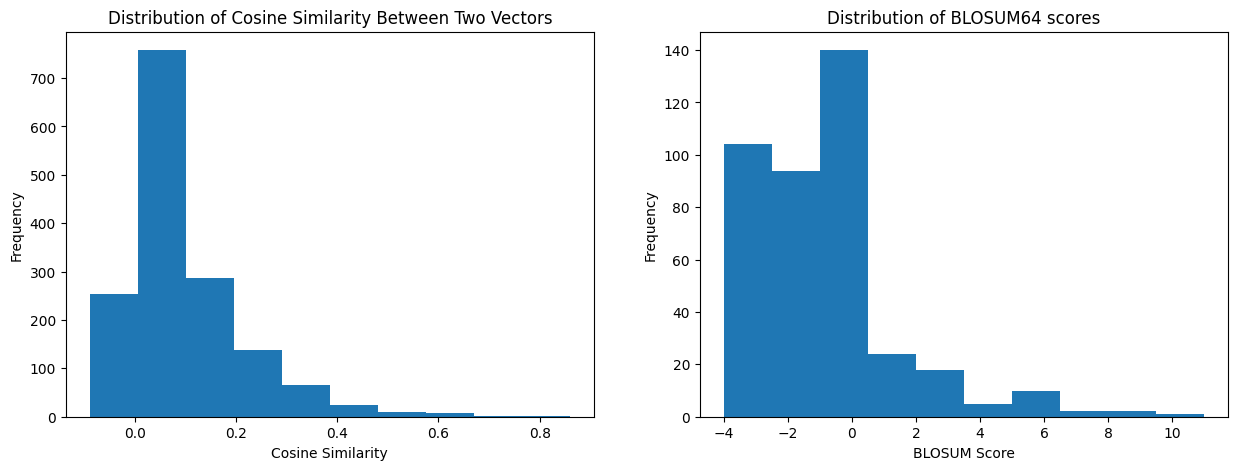

In [97]:
import matplotlib.pyplot as plt

# Compare distribution of cosine scores to distribution of BLOSUM scores
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(cos_scores)#, bins = [i*0.1 for i in range(0, 11)])
axes[0].set_title('Distribution of Cosine Similarity Between Two Vectors')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[1].hist(blosum_scores)
axes[1].set_title('Distribution of BLOSUM64 scores')
axes[1].set_xlabel('BLOSUM Score')
axes[1].set_ylabel('Frequency')